In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_uint), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.POINTER(ctypes.c_void_p)

mlp_model.mlpTrain.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t
]
mlp_model.mlpTrain.restype = ctypes.c_double


mlp_model.mlpPredict.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.POINTER(ctypes.c_void_p)]
mlp_model.mlpFree.restype = None


# First test case

In [3]:
parameter = np.array([2, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
callback_interval = 100

parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {X_train.shape}')

layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.31323118643762493, 0.7630317642285571]], bias: [0.0], input_size: 2, output_size: 1 }]
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]]
vecteur (3, 2)


In [4]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,  # Nombre total d'époques
    1,
    True,  # is_classification
    callback_func,  # Fonction de callback
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [5]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

mlp_model.mlpFree(nn)

Sample [0. 0.] , predictions = [-0.9999405]
Sample [0. 1.] , predictions = [0.9999762]
Sample [1. 0.] , predictions = [0.9999762]


# Xor test case

In [6]:
neurons_size = np.array([2, 3, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.46626457206765615, 0.8908084395716771], [0.26660317402734046, -0.21125663834197628], [0.670207443785622, -0.3802487127580356]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }, NeuralMatrix { matrix: [[0.4857869289816037, 0.014738796039909463, 0.5636678692090973]], bias: [0.0], input_size: 3, output_size: 1 }]


In [7]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,  # Nombre total d'époques
    16,
    True,  # is_classification
    callback_func,  # Fonction de callback
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [8]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)
mlp_model.mlpFree(nn)

Sample [0. 0.] , predictions = [-0.99853411]
Sample [0. 1.] , predictions = [0.99864035]
Sample [1. 0.] , predictions = [0.99864031]
Sample [1. 1.] , predictions = [-0.9986794]


# Multi class test

In [9]:
neurons_size = np.array([2, 3], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [1.0, 1.0],  # Classe A
    [5.0, 5.0],  # Classe B
    [9.0, 9.0] 
], dtype=np.float64)

y_train = np.array([
    [1.0, 0.0, 0.0],  # Classe A
    [0.0, 1.0, 0.0],  # Classe B
    [0.0, 0.0, 1.0]   # Classe C
], dtype=np.float64)


layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.23959959936843145, 0.3039162160688602], [0.6267960523261049, -0.4271689227211559], [-0.78067338579844, -0.6368446696301016]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [10]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    3,
    epochs,
    16,
    True,  
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [11]:
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)
mlp_model.mlpFree(nn)

Sample [1. 1.] , predictions = [9.97190234e-01 2.80976541e-03 4.46040260e-10]
Sample [5. 5.] , predictions = [6.12546773e-04 9.92856666e-01 6.53078698e-03]
Sample [9. 9.] , predictions = [3.92060434e-12 3.65557392e-03 9.96344426e-01]


# Simple linear test

In [12]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.8320288128328697]], bias: [0.0], input_size: 1, output_size: 1 }]


In [13]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    1,
    False,
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [14]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [8.]
Sample [7.] , predictions = [2.]


# Linear test

In [15]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 100000
callback_interval = 1000

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
    [9.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
    [6.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.3039069364161402]], bias: [0.0], input_size: 1, output_size: 1 }]


In [16]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    16,
    False,
    callback_func,
    callback_interval  
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
allPrediction = []
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    allPrediction.append(predictions)
    print("Sample", X_train[k], ", predictions =", predictions)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [6.98901604]
Sample [7.] , predictions = [5.03605573]
Sample [9.] , predictions = [4.05957558]


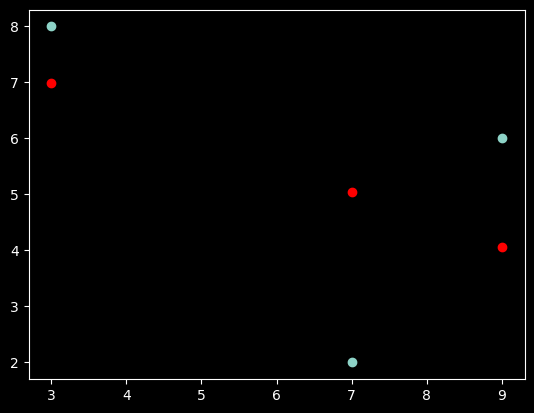

In [18]:
plt.scatter(X_train, y_train)
plt.scatter(X_train, allPrediction, c='red')
plt.show()